In [1]:
import re

with open('./data/LegalBench-RAG/corpus/privacy_qa/Fiverr.txt') as f:
    data = f.read()

SENTENCE_SPLIT = re.compile(r'\n\s*')
raw_sentences = SENTENCE_SPLIT.split(data)
print(f'sentence count: {len(raw_sentences)}')
raw_sentences[:3]

sentence count: 174


['  At Fiverr we care about your privacy.',
 'We do not sell or rent your personal information to third parties for their direct marketing purposes without your explicit consent.',
 'We do not disclose it to others except as disclosed in this Policy or required to provide you with the services of the Site and mobile applications, meaning - to allow you to buy, sell, share the information you want to share on the Site; to contribute on the forum; pay for products; post reviews and so on; or where we have a legal obligation to do so.']

In [2]:
def combine_sentences(sentences, pad=2):
    combined_sentences = []
    for i in range(len(sentences)):
        window = sentences[max(0, i - pad):i + 1 + pad]
        combined_sentences.append(' '.join(window))
    return combined_sentences
combined_sentences = combine_sentences(raw_sentences)
combined_sentences[:3]

['  At Fiverr we care about your privacy. We do not sell or rent your personal information to third parties for their direct marketing purposes without your explicit consent. We do not disclose it to others except as disclosed in this Policy or required to provide you with the services of the Site and mobile applications, meaning - to allow you to buy, sell, share the information you want to share on the Site; to contribute on the forum; pay for products; post reviews and so on; or where we have a legal obligation to do so.',
 '  At Fiverr we care about your privacy. We do not sell or rent your personal information to third parties for their direct marketing purposes without your explicit consent. We do not disclose it to others except as disclosed in this Policy or required to provide you with the services of the Site and mobile applications, meaning - to allow you to buy, sell, share the information you want to share on the Site; to contribute on the forum; pay for products; post rev

In [3]:
from sentence_transformers import SentenceTransformer
from transformers import BitsAndBytesConfig


model = SentenceTransformer(
    "Qwen/Qwen3-Embedding-8B",
    model_kwargs={"quantization_config": BitsAndBytesConfig(load_in_8bit=True)}
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [4]:
embeddings = model.encode(
    combined_sentences,
    show_progress_bar=True,
)

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

In [6]:
%matplotlib inline

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt


def pairwise_cosine_distances(embeddings):
    distances = []
    for i in range(len(embeddings) - 1):
        distances.append(1 - embeddings[i] @ embeddings[i + 1])
    return distances
    
distances = pairwise_cosine_distances(embeddings)

Using matplotlib backend: inline


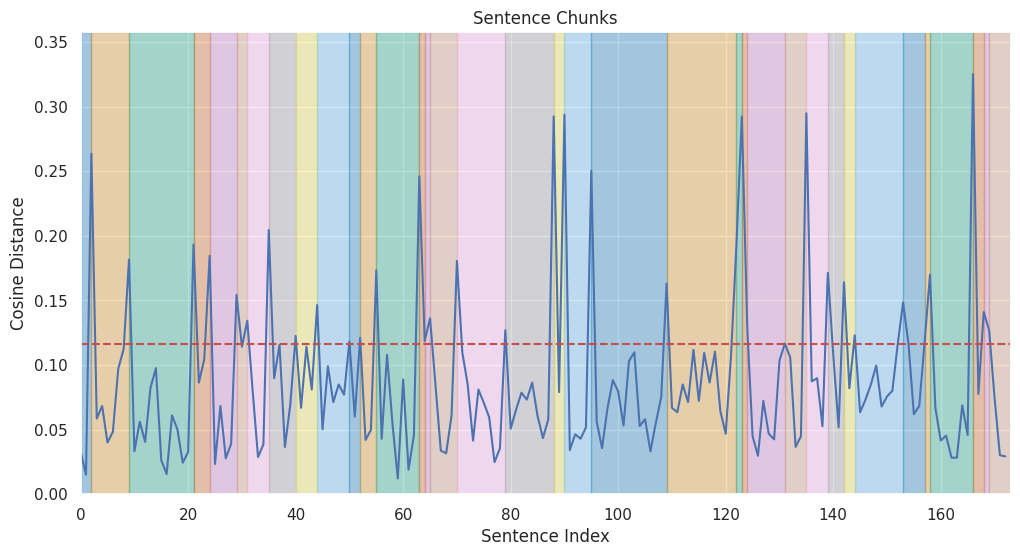

In [11]:
%matplotlib

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


PERCENTILE = 80

# plot distances
plt.figure(figsize=(12, 6))
sns.lineplot(distances);

# set bounds
y_upper = 1.1 * max(distances)
plt.xlim(0, len(distances))
plt.ylim(0, y_upper)

# draw threshold line

threshold = np.percentile(distances, PERCENTILE)
plt.axhline(threshold, color='r', linestyle='--')

colors = sns.color_palette('colorblind')
threshold_idxs = np.where(distances > threshold)[0]

chunk_starts = [0] + list(threshold_idxs)
chunk_ends = list(threshold_idxs) + [len(distances)]
for i, (start, end) in enumerate(zip(chunk_starts, chunk_ends)):
    plt.axvspan(start, end, color=colors[i % len(colors)], alpha=0.3, label=f'Chunk {i}')

plt.title('Sentence Chunks')
plt.xlabel('Sentence Index')
plt.ylabel('Cosine Distance')
plt.show()

In [12]:
chunks = []
chunk_idxs = [0] + list(threshold_idxs + 1) + [len(distances)]  # The split index is after the high distance 
for start, end in zip(chunk_idxs[:-1], chunk_idxs[1:]):
    chunks.append(' '.join(raw_sentences[start:end]))

In [18]:
for i, chunk in enumerate(chunks[:5]):
    buffer = 200
    
    print (f"Chunk #{i} (length={len(chunk)})")
    print (chunk[:buffer].strip())
    print ("...")
    print (chunk[-buffer:].strip())
    print ("\n")

Chunk #0 (length=527)
At Fiverr we care about your privacy. We do not sell or rent your personal information to third parties for their direct marketing purposes without your explicit consent. We do not disclose it to ot
...
ng - to allow you to buy, sell, share the information you want to share on the Site; to contribute on the forum; pay for products; post reviews and so on; or where we have a legal obligation to do so.


Chunk #1 (length=1429)
We collect information that you provide us or voluntarily share with other users, and also some general technical information that is automatically gathered by our systems, such as IP address, browser
...
ty service providers acting on our behalf. These providers may be based in countries that do not provide an equivalent level of protection for privacy as that enjoyed in the country in which you live.


Chunk #2 (length=1564)
In that case, we will provide for adequate safeguards to protect your personal information. You can exercise your righ

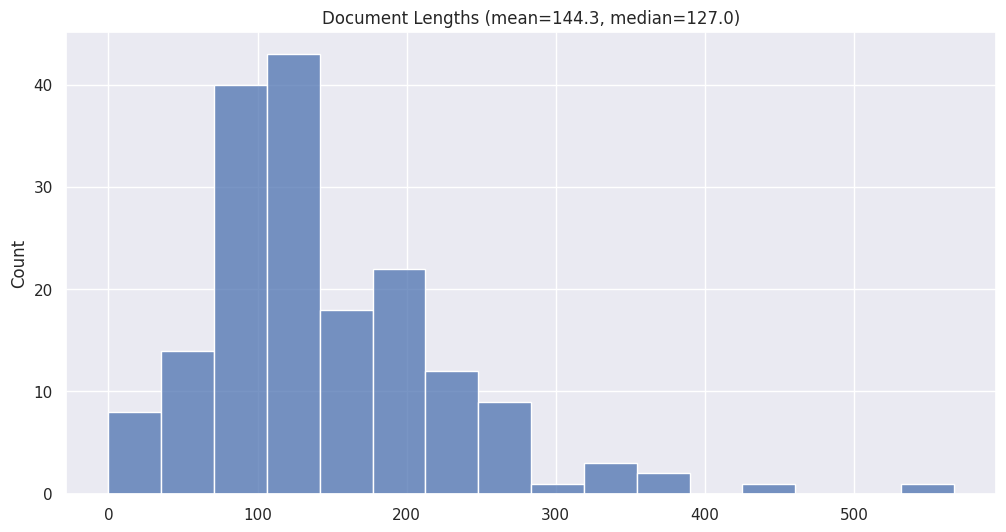

In [17]:
%matplotlib inline

import statistics
import matplotlib.pyplot as plt
import seaborn as sns


sns.set_theme()

lengths = [len(chunk) for chunk in raw_sentences]

plt.figure(figsize=(12, 6))
sns.histplot(lengths)
plt.title(f"Document Lengths (mean={statistics.mean(lengths):.1f}, median={statistics.median(lengths):.1f})")
plt.show()

In [19]:
max(raw_sentences, key=len)

'to respond to a subpoena or court order, judicial process or to regulatory authorities, if we believe we are required to do so by law, or that doing so is reasonably necessary to comply with legal processes; when we believe it necessary or appropriate to disclose personal information to law enforcement authorities, such as to investigate actual or suspected fraud or violations of law, breaches of security, or breaches of this Policy; to respond to claims against us; and to protect the rights, property, or personal safety of Fiverr, our customers, or the public;'